Check for the required packages

In [1]:
%%bash

pip list > installed_packages

check_package() {
    if grep -q $1 installed_packages; then
        echo Package $1 is installed
    else
        echo installing $1
        pip install $1
    fi
}

check_package "pandas"
check_package "matplotlib"
check_package "seaborn"
check_package "ipywidgets"

Package pandas is installed
Package matplotlib is installed
Package seaborn is installed
Package ipywidgets is installed


Check out the repository

In [2]:
%%bash 

if [[ -d covid-19 ]]; then
    cd covid-19
    git pull
    cd ..
else
    git clone https://github.com/datasets/covid-19
fi

ls -lt covid-19

Updating 1162f23..9ecc3cc
Fast-forward
 data/countries-aggregated.csv          |   269 +-
 data/key-countries-pivoted.csv         |     1 +
 data/time-series-19-covid-combined.csv |  2460 +-
 data/us_confirmed.csv                  | 60670 ++++++++++++++++---------------
 data/us_deaths.csv                     | 60670 ++++++++++++++++---------------
 data/worldwide-aggregated.csv          |    89 +-
 datapackage.json                       |    30 +-
 7 files changed, 65582 insertions(+), 58607 deletions(-)
total 48
-rw-r--r--  1 syad  staff  15844 Apr 28 11:18 datapackage.json
drwxr-xr-x  9 syad  staff    288 Apr 28 11:18 data
drwxr-xr-x  4 syad  staff    128 Apr 27 20:43 scripts
-rw-r--r--  1 syad  staff   4612 Apr 27 20:43 README.md


From https://github.com/datasets/covid-19
   1162f23..9ecc3cc  master     -> origin/master


And the packages we're going to use for the visualization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read the aggregated data of all countires

In [4]:
df = pd.read_csv("./covid-19/data/countries-aggregated.csv")

In [5]:
df.columns

Index(['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

Lower the cases of all the columns to make it easier to work with names

In [6]:
df.columns = map(str.lower, df.columns)

In [7]:
df

,date,country,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-22,Albania,0,0,0
2,2020-01-22,Algeria,0,0,0
3,2020-01-22,Andorra,0,0,0
4,2020-01-22,Angola,0,0,0
...,...,...,...,...,...
17940,2020-04-27,West Bank and Gaza,342,83,2
17941,2020-04-27,Western Sahara,6,5,0
17942,2020-04-27,Yemen,1,1,0
17943,2020-04-27,Zambia,88,42,3


In [8]:
df[df['country'] == 'Afghanistan']

,date,country,confirmed,recovered,deaths
0,2020-01-22,Afghanistan,0,0,0
185,2020-01-23,Afghanistan,0,0,0
370,2020-01-24,Afghanistan,0,0,0
555,2020-01-25,Afghanistan,0,0,0
740,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
17020,2020-04-23,Afghanistan,1279,179,42
17205,2020-04-24,Afghanistan,1351,188,43
17390,2020-04-25,Afghanistan,1463,188,47
17575,2020-04-26,Afghanistan,1531,207,50


Clean up the names and make a list of all the countries

In [9]:
country_names = [name for name in list(set(df['country']))]

Create a separate dataframe for each country and filter out those with no cases

In [10]:
dfs = {country: df[df['country'] == country] for country in country_names}

In [11]:
dfs = {country: dfs[country] for country in dfs if len(dfs[country]) > 0}

We're going to need the new cases for each day (call it `new_cases`). The `pd.option` is a workaround so we don't get the warning message

In [12]:
# https://stackoverflow.com/questions/21463589/pandas-chained-assignments
pd.options.mode.chained_assignment = None

def add_new_cases(df):
    df.loc[:, 'new_cases'] = df['confirmed'].diff().fillna(0, downcast='infer')
    return df

def add_new_deaths(df):
    df.loc[:, 'new_deaths'] = df['deaths'].diff().fillna(0, downcast='infer')
    return df

See how data frame for each country looks like, for exmaple for `Germany` after adding new cases and new deaths:

In [411]:
add_new_deaths(add_new_cases(dfs['Germany']))

,date,country,confirmed,recovered,deaths,new_cases,new_deaths
65,2020-01-22,Germany,0,0,0,0,0
250,2020-01-23,Germany,0,0,0,0,0
435,2020-01-24,Germany,0,0,0,0,0
620,2020-01-25,Germany,0,0,0,0,0
805,2020-01-26,Germany,0,0,0,0,0
...,...,...,...,...,...,...,...
17085,2020-04-23,Germany,153129,103300,5575,2481,296
17270,2020-04-24,Germany,154999,109800,5760,1870,185
17455,2020-04-25,Germany,156513,109800,5877,1514,117
17640,2020-04-26,Germany,157770,112000,5976,1257,99


`dfs` contains all the data we'll work with later:

In [413]:
dfs = {country: add_new_deaths(add_new_cases(dfs[country])) for country in country_names}

We only consider countries at the top of the list to declutter the plot area. You can change the threshold or ignore it, but especially for debugging it's a good idea to only work with a handful of countries at the top of the list

In [412]:
max_cases = 140000

countries_large = [country_name for country_name in country_names if dfs[country_name]['confirmed'].iloc[-1] > max_cases]

In [16]:
countries_large

['US', 'Spain', 'United Kingdom', 'Italy', 'France', 'Germany']

Before putting it all together, we create a little prototype of the plots we want to have later

In [414]:
de = dfs['Germany']
de

,date,country,confirmed,recovered,deaths,new_cases,new_deaths
65,2020-01-22,Germany,0,0,0,0,0
250,2020-01-23,Germany,0,0,0,0,0
435,2020-01-24,Germany,0,0,0,0,0
620,2020-01-25,Germany,0,0,0,0,0
805,2020-01-26,Germany,0,0,0,0,0
...,...,...,...,...,...,...,...
17085,2020-04-23,Germany,153129,103300,5575,2481,296
17270,2020-04-24,Germany,154999,109800,5760,1870,185
17455,2020-04-25,Germany,156513,109800,5877,1514,117
17640,2020-04-26,Germany,157770,112000,5976,1257,99


A one-liner for calculating moving averages 

In [18]:
moving_average = lambda df, n: df.rolling(n).mean().fillna(0).map(np.floor).map(int)

And the plot prototype is something like this:

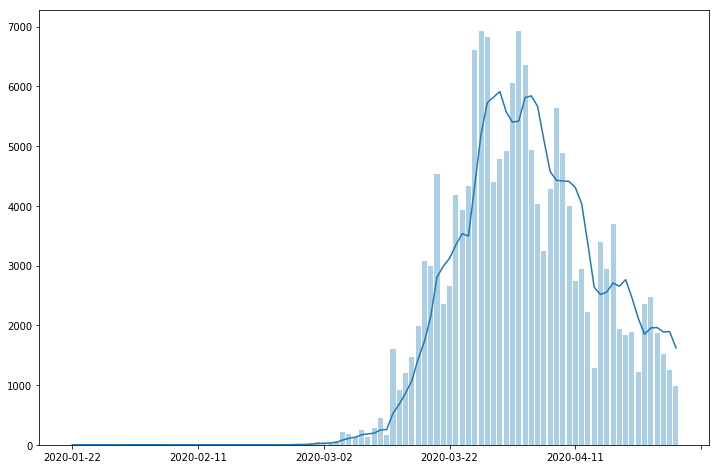

In [22]:
cl = [sns.color_palette("Blues_r", 5)[3]] * len(de)
cl0 = sns.color_palette("Blues_r", 5)[3]

de = dfs['Germany']

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(de['date'], de['new_cases'], fc=cl0)
ax.plot(de['date'], moving_average(de['new_cases'], 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(7))


I didn't put a check for `ipywidgets` package. You can find the installation instructions in the following [page](https://ipywidgets.readthedocs.io/en/latest/user_install.html:link)

In [324]:
from ipywidgets import Layout, Output, HBox, VBox, Label, Button
from ipywidgets import RadioButtons, IntRangeSlider, IntSlider, GridspecLayout, Checkbox, ColorPicker, Textarea, Dropdown, IntText, FloatText

In [374]:
country_default = countries_large[0]
day_default = 5
color_default = 'red'
thickness_default = 1.5

In [407]:
%matplotlib widget

output = Output()

with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

fig.canvas.toolbar_position = 'bottom'    

The list of widgets and their callbacks are as follows

In [408]:
# Widgets
layout_checkbox = Layout(width='50px', height='50px')
layout_list = Layout(width='90px', height='30px')

mov_ave = Checkbox(description='moving average')
log_scale = Checkbox(description='log scale')
y_lim = Checkbox(description='y limit')

mov_ave_slider = IntSlider(description='mov ave days', value=day_default, min=2, max=10)
mov_ave_slider.disabled = True

color_picker = ColorPicker(description='mov ave color')
color_picker.value = color_default
thickness = FloatText(description='mov ave thickness', step=0.1)
thickness.value = 1.5

country_list = Dropdown(description='Country', value=country_default, options=countries_large)

# helpers
def set_all_visible_except(name):
    for _ in h_plt:
        h_plt[_].set_visible(True)
    h_plt[name].set_visible(False)


def set_ylim_bottom():
    if log_scale.value:
        ax.set_ylim(bottom=1.0)
    else:
        ax.set_ylim(bottom=0.0)
        
        
def set_ylim_top(name):
    ax.set_ylim(top=dfs[name]['new_cases'].max() * 1.1)
    

# Callbacks
def update_ylim(value):
    if value:
        set_ylim_top(country_list.value)
        set_ylim_bottom()
    else:
        ax.set_ylim(top=80000)
        set_ylim_bottom()
        

def update_country_list(value):
    df = dfs[value]
    for h, y in zip(h_bar, df['new_cases']):
        h.set_height(y)
    set_all_visible_except(value)
    update_ylim(y_lim.value)
    update_mov_ave(mov_ave.value)


def update_mov_ave(value):
    if value:
        mov_ave_slider.disabled = False
        #draw
        update_mov_ave_slider(mov_ave_slider.value)
        h_ave.set_visible(True)
    else:
        mov_ave_slider.disabled = True
        h_ave.set_visible(False)

def update_mov_ave_slider(value):
    h_ave.set_ydata(moving_average(dfs[country_list.value]['new_cases'],
                                       mov_ave_slider.value))


def update_log_scale(value):
    if value:
        set_ylim_bottom()
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')        
        set_ylim_bottom()        


def update_mov_ave_color(value):
    h_ave.set_color(value)


def update_mov_ave_thicknes(value):
    h_ave.set_lw(value)

The use of `lambda` in the followings is for extracting the `.new` from the values, so we can use callback functions indirectly when updates on other widget. For exmaple, an update on log scale has to take care of the lower limit of the plot, or an update on country list has to recalculate the limits of the plot. There is probably some idiomatic way to do it without lambda expression though but I couldn't find it in the documentation.

In [ ]:
country_list.observe(lambda x: update_country_list(x.new), 'value')
mov_ave.observe(lambda x: update_mov_ave(x.new), 'value')
mov_ave_slider.observe(lambda x: update_mov_ave_slider(x.new), 'value')
y_lim.observe(lambda x: update_ylim(x.new), 'value')
log_scale.observe(lambda x: update_log_scale(x.new), 'value')
color_picker.observe(lambda x: update_mov_ave_color(x.new), 'value')
thickness.observe(lambda x: update_mov_ave_thicknes(x.new), 'value')

We just replicate the plots from the prototype and save the handles since we need them to modify the plots in the callbacks

In [409]:
# Plots

pltargs = {'lw': 0.2, 'color': 'b'}
h_plt = {}
for country in countries_large:
    df = dfs[country]
    h_plt[country], = ax.plot(df['date'], df['new_cases'], **pltargs)

df = dfs[country_list.value]

h_bar = ax.bar(df['date'], df['new_cases'], color=cl0)
set_all_visible_except(country_list.value)

h_ave, = ax.plot(df['date'], moving_average(df['new_cases'], 5), 
                color=color_default, lw=thickness_default)
h_ave.set_visible(False)

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

Putting it all together with `GridspecLayout`, which is similar to `matplotlib.gridspec.GridSpec`

In [410]:
grid = GridspecLayout(n_rows=12, n_columns=3, width='300x',
                     justify_content='flex-start', align_items='flex-start')
grid[0, 0] = country_list
grid[0, 1] = mov_ave
grid[0, 2] = log_scale
grid[2, 0] = y_lim

grid[1, 0] = mov_ave_slider

grid[1, 1] = color_picker
grid[1, 2] = thickness
grid[3:, :] = output

update_ylim(y_lim.value)
#update_mov_ave(mov_ave.value)
update_log_scale(log_scale.value)


grid



GridspecLayout(children=(Dropdown(description='Country', layout=Layout(grid_area='widget001'), options=('US', …

### TODOs:

- A date range selector

- Better arrangement of the widgets